Cracking open the intermediate layers of a Convolutional Neural Network can be incredibly instructive and help reinforce your intuition for the types of features learned within a "black box" algorithm. However, from an image classification standpoint, it's hard to overstate just how effective seeing a simple heatmap of "decision attribution" can be for debugging and understanding the behavior of your model as a whole.

In this notebook, we'll give a quick overview of an approach that lets us achieve just that-- adapted from Chapter 5 of Chollet's excellent Deep Learning book.

## Our Image

Almost every time I tell a stranger that I played the [mellophone](https://en.wikipedia.org/wiki/Mellophone) in the MMB, I'm met with a blank stare. It's only after I describe it as "basically a fat trumpet" do I get appreciable nods.

The [ImageNet dataset](http://image-net.org/about-overview) is a popular image dataset in the data science arena with 14M images in over 20K different classes of "thing." For our purposes, we'll download a pre-trained model that comes, batteries-included, ready to organize images it sees into one of these 20 thousand classes.

Ultimately, we want to see:

1. What this model thinks it's looking at

2.  What parts of the image it arrived at this guess from

And so we load the model

In [1]:
%pylab inline

import helpers

from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


And snag a picture of a mellophone from the Internet

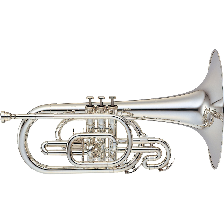

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = './images/mello.jpeg'

img = image.load_img(img_path, target_size=(224, 224))

img

Ain't it pretty?

Then we convert this image into a matrix of values that our model can consume

In [3]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

And ask it what it thinks it's looking at

In [4]:
preds = model.predict(x)

Go figure, this near-state-of-the-art model thinks it's looking at a trumpet (cornet) with about 96% certainty

(Bonus points for French Horn-- the more appropriate guess, sound-wise-- being the runner-up candidate)

In [5]:
decode_predictions(preds)

[[('n03110669', 'cornet', 0.96294755),
  ('n03394916', 'French_horn', 0.02380206),
  ('n04141076', 'sax', 0.0053833486),
  ('n04487394', 'trombone', 0.0046766168),
  ('n03838899', 'oboe', 0.00057546276)]]

But now the meat-and-potatoes of this post:

*Why* did it think this?

## Attribution in ConvNets

If you squint, this approach might look similar to our ["use the gradients" approach for finding "filter essence"](https://napsterinblue.github.io/notes/machine_learning/computer_vision/interpretable_filter_essence/).

We're basically going to peek at the very last of the Convolutional Layers (before the Network gets all Dense on us...), and inspect all 512 of the filters that get passed on. More accurately, we're going to generate a vector of shape `(512,)`, where each entry is the mean intensity of the gradient *for that specific channel filter*.

This will require a lot of functional programming and `keras` magic, so we'll load up the backend

In [6]:
from keras import backend as K

Then, using [this handy GitHub gist](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt-L514), we'll zero in on the `513`th index of the model output, which is the probability that the image is a cornet.

**Note**: `Dimension(None)` for the output shape actually means a *singular value* (the `[0-1]` prediction) for as many records as we're looking at at once

In [7]:
cornet_idx = 513

cornet_output = model.output[:, cornet_idx]
cornet_output.shape

TensorShape([Dimension(None)])

Similarly, we take the last Convolutional layer.

In [8]:
last_conv_layer = model.get_layer('block5_conv3')

last_conv_layer.output

<tf.Tensor 'block5_conv3/Relu:0' shape=(?, 14, 14, 512) dtype=float32>

Breaking down the dimaensionality here, we've got:

- `?`: Again, this means "for as many records as we're looking at at once"
- `14, 14`: The image passed to the next layer is `14 x 14` pixels
- `512`: There are 512 filter channels at this point in the model, each looking for different features in the image
    - Scroll to the bottom of [this notebook]
    (https://napsterinblue.github.io/notes/machine_learning/computer_vision/interpretable_filter_essence/) for a clearer picture of the kinds of things the filters are looking for

### The Tricky, Functional Part

Next, we define a variable that will represent our activation gradients

In [9]:
grads = K.gradients(loss=cornet_output, variables=last_conv_layer.output)[0]

The docstring for our call of `K.gradients(loss, variables)` reads:

    Returns the gradients of `loss` w.r.t. `variables`.
    
So to unpack a little: each of the 512 filters found in the output of `last_conv_layer` are of size `14x14` and have *some* differentiable gradient function that Chain Rule's up to the loss function parked at the end of the model, `cornet_output`.

`grads` isn't the activations/synapses that go from one layer of the Network to the next, but *their same-dimensional derivative values at any given point*.

Thus, we expect the *output shape* for this layer to be preserved

In [10]:
grads.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

But also consistently-shaped, so that we can define `pooled_grads`, the average gradient activation value **for each filter**

In [11]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

Calling `K.mean()` on `512` different `14x14` filters yields `512` single-value averages. Neat.

In [12]:
pooled_grads

<tf.Tensor 'Mean:0' shape=(512,) dtype=float32>

Next, we need some scheme that'll take us from "`14x14x512` and a lot of data" to just.... `heatmap`

##### These next few cells merit some reading, rereading, and re-rereading as they're devilishly clever.

`iterate` serves as a generic method that takes an image of size `model.input` and returns our average filter gradients and what each of the `14x14` filters looked like.

In [13]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [14]:
iterate = K.function(inputs=[model.input],
                     outputs=[pooled_grads, last_conv_layer.output[0]])

These two variables are, again, functional placeholders that represent the underlying `Tensor` objects.

They're used to evoke `iterate` on our original image, `x`, and yield two concrete `numpy` arrays:

In [15]:
pooled_grads_value, conv_layer_output_value = iterate([x])

`pooled_grads_value` is the average activation value for each filter, used to determine *each filter's contribution to the overall pixel-level activation*

In [16]:
pooled_grads_value.shape

(512,)

and `conv_layer_output_value` is the actual `14x14` display of each of the 512 filters

In [17]:
conv_layer_output_value.shape

(14, 14, 512)

**THIS IS THE CRUX OF THIS WHOLE METHOD**

Here, we cycle through all 512 filters and essentially "scale" each of the `14x14x1` outputs relative to how activated they are. For instance:

- If the average activation is *low*, then *all* values for a given filter will be much lower
- Conversely, if they're high, the parts that signaled the activation will be more prominent

In [18]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]    

So iteratively multiplying `*=` each `pooled_grads_value` in lockstep with its respective filter allows a sort of "normalizing" effect.

After we've done that for each filter, we average together the "normalized activation values" at the pixel-level, and areas that didn't do much in the way of positive activation will effectively come out in the wash.

In [19]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

As expected, this gives us a single `14x14` image of the parts of the image that mattered, on average, to these different activation layers.

In [20]:
heatmap.shape

(14, 14)

Intuitively, this should track. Say you've got a filter looking for, say, eyes, and you've got one right in the center of your picture. The `[0-1]` values in this filter's gradient should be pretty close to `1` in the pixels around the eye, and the average activation for this image will likely be higher than all other filters.

So when you consider *this filter's* addition to the overall averaging, the areas that it adds the most positive value will be *at the location that activated the filter*.

You might have other areas looking for wheels or wings. Not only will these filters *not* be bright at any particular place, their entire filter will be, on average, dark. Then the further-dampening of this filter will basically make it a trivial addition to the final, aggregate, `14x14` heatmap.

Extend this to, say, areas activated by a filter looking for ears, and areas looking for tongues hanging out. These areas, after averaging in, will be brighter in the aggregated final image.

Ultimately, when you look at your final heatmap you'll see that, on average, you have higher activation around the eyes, ears, and big ol' tongues, which led your model to predict that the picture of a dog was, indeed, a picture of a good old boye.

## Applying the Heatmap

And so after running this algorithm over our image, we've got the following.

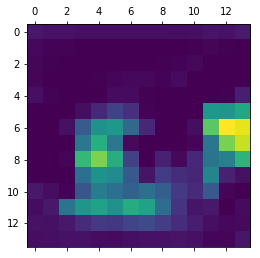

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap);

But we want to overlay this `14x14` image atop our original, much-larger picture of a mellophone, so we'll leverage `cv2` to do some resizing.

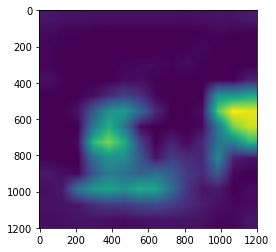

In [22]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
plt.imshow(heatmap);

Finally, we'll translate from a heatmap representing the span between `[0, 1]` on a single axis, to their actual `(R, G, B)` values.

In [23]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

In [24]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

Overlay it atop our original image and save

In [25]:
superimposed_img = heatmap * 0.5 + img

cv2.imwrite('mello_heatmap.png', superimposed_img);

Then we'll load up the result

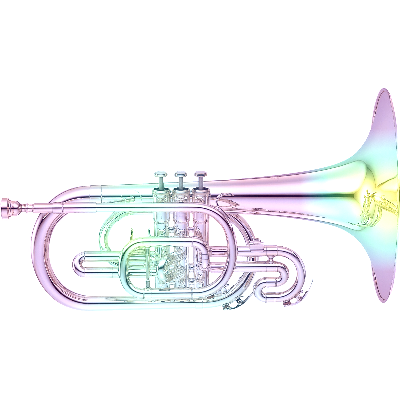

In [26]:
image.load_img('mello_heatmap.png', target_size=(400, 400))

Turns out it strongly considers the bell and the piping behind the first valve when answering "What *is* a trumpet?"

Huh.